In [1]:
from tensorflow.keras.models import load_model
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

loaded_model = load_model('saved_models/NVspin_LSTM_model_cuda_LearningRate.h5')

2023-09-18 10:48:50.620805: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-18 10:48:51.163820: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-18 10:48:51.970265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-18 10:48:52.000333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-18 10:48:52.000387: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_exec

In [2]:
import numpy as np
import random
from math import *
import cmath
from scipy.linalg import expm, fractional_matrix_power

#########################################################################

# pauli matrix 
sx = np.array([[0,  1],     [1, 0]])
sy = np.array([[0, -1j],   [1j, 0]])
sz = np.array([[1, 0],     [0, -1]])
s0 = np.array([[1, 0],      [0, 1]])

# parameters(detuning factor)
v0 = 0.02           # Arbitrary settings, Actual speed : 0.04rad/μs
d0 = 0.15           # Arbitrary settings, Actual speed : 0.30rad/μs
dt = 2.6 


# unitary operator
def unitary(dt, choice):
    
    # Select x,y-rotation direction.
    # [stay, +x, -x, +y, -y]
    choice_list = [0, 1, -1, 1, -1] 
    
    if choice < 3:
        # if choice = 0 ... only d0*sz
        Ham = (d0*sz+v0*choice_list[choice]*sx)
    else:
        Ham = (d0*sz+v0*choice_list[choice]*sy)

    # Creating a Unitary Operator for each of the four sections by Hamiltonian
    eigvals = np.linalg.eigh(Ham)[0]
    eigvecs = 1*np.linalg.eigh(Ham)[1]
    E = np.diag(eigvals)
    U_H = eigvecs.conj().T
    U_e = U_H.conj().T @ expm(-1j*E*dt) @ U_H
    
    return U_e


#########################################################################

# x-rotation operater
def Rx(theta):
    return np.matrix([  [cos(theta/2),    -1j*sin(theta/2)],
                        [-1j*sin(theta/2),    cos(theta/2)]])

# z-rotation operater
# Do not use Rz. Control by rotation only by Hamiltonian.
def Rz(phi): 
    return np.matrix([  [cos(phi/2)-1j*sin(phi/2),  0],
                        [0,  cos(phi/2)+1j*sin(phi/2)]])

# Calculating the Fidelity
def state_fidelity(rho_1, rho_2): 
    
    # rho_1(current state), rho_2(target state)
    # Calculate the fidelity after checking the dimensions of the two states.
    
    if np.shape(rho_1) != np.shape(rho_2):
            print("Dimensions of two states do not match.")
            return 0
    else:
        sqrt_rho_1 = fractional_matrix_power(rho_1, 1 / 2)
        fidelity = np.trace(fractional_matrix_power(sqrt_rho_1 @ rho_2 @ sqrt_rho_1, 1 / 2)) ** 2
        return np.real(fidelity)


#########################################################################

init_wave = np.array([[1], [0]])
irho_init = np.kron(init_wave,init_wave.conj().T)


def fidelity(target_theta, target_phi):
    
    target_U = Rz(target_phi) @ Rx(target_theta)
    irho_target = target_U @ irho_init @ target_U.conj().T

    new_theta = np.array(target_theta).reshape(-1, 1)
    new_phi = np.array(target_phi).reshape(-1, 1)
    predicted_sequence = loaded_model.predict([new_theta, new_phi])

    predicted_sequence_indices = np.argmax(predicted_sequence, axis=-1)

    Uni = s0
    U_0 = unitary(dt, 0)
    U_1 = unitary(dt, 1)
    U_2 = unitary(dt, 2)
    U_3 = unitary(dt, 3)
    U_4 = unitary(dt, 4)
    
    pulse_list = [U_0, U_1, U_2, U_3, U_4]
    
    for i in predicted_sequence_indices[0]:
        Uni = pulse_list[i] @ Uni

    irho_final = Uni @ irho_init @ Uni.conj().T
    
    F = (state_fidelity(irho_final,irho_target))
    
    return  F

In [3]:
sum = 0
iter = 10000
fidelities = []
low_fidelities = {'theta':[], 'phi':[], 'fidelity':[]}

for i in range(iter) :     
     
     target_theta = np.pi / 180 * random.uniform(0,180)
     target_phi = np.pi / 180 * random.uniform(0,360)
     
     temp = fidelity(target_theta, target_phi)
     fidelities.append(temp)
     
     if temp < 0.99:
          low_fidelities['theta'].append(target_theta)
          low_fidelities['phi'].append(target_phi)
          low_fidelities['fidelity'].append(temp)
     
     sum += temp

print(sum/iter)

1/1 [==============================] - 0s 14ms/step


2023-09-18 10:48:54.546804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-18 10:48:54.638759: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 0s 16ms/step
0.9868163109231175


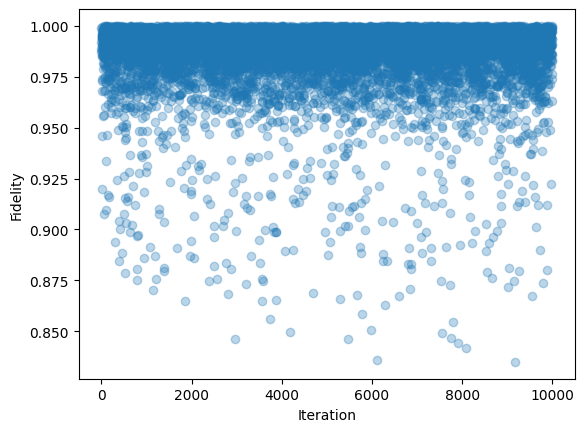

In [4]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(range(iter), fidelities, alpha=0.3)
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.show()

In [5]:
temp = 0
sum = 0

for i in fidelities:
     temp += 1 
     if i < 0.99:
          sum += 1
          print(temp, i)

print(sum)
print(np.std(fidelities))
print(min(fidelities))

2 0.9885223147092133
3 0.9870304156418078
8 0.9461243267994446
11 0.9849891482952731
13 0.9899133212236253
15 0.9739929896188105
16 0.9731245556722891
17 0.9678402315027579
19 0.9850763014332496
23 0.9199241580164192
25 0.9888119609448586
26 0.9875645865387632
28 0.9875679129308794
32 0.9819463808812253
33 0.9857146918706589
36 0.955712545606068
37 0.9787074972642502
41 0.988804615266464
43 0.9885168937537216
44 0.9855846116145093
47 0.984619559988918
50 0.9890684699117365
51 0.9856992613740572
52 0.9075678900067996
56 0.9560488546583852
59 0.9849630678772651
61 0.9678848881416678
62 0.9816279196211034
64 0.9743426196897479
67 0.9805772244399867
71 0.9894885904128944
77 0.9835342738397028
78 0.9890386201772204
82 0.9750609991904087
83 0.9854690930260047
85 0.9793179620500554
88 0.9682654136577372
90 0.9724697980938978
92 0.9603446958946481
93 0.9872533816549436
96 0.9851539735379929
98 0.9835741985084933
99 0.9887059311228283
100 0.9719876023573385
102 0.9805009244113038
103 0.93339650

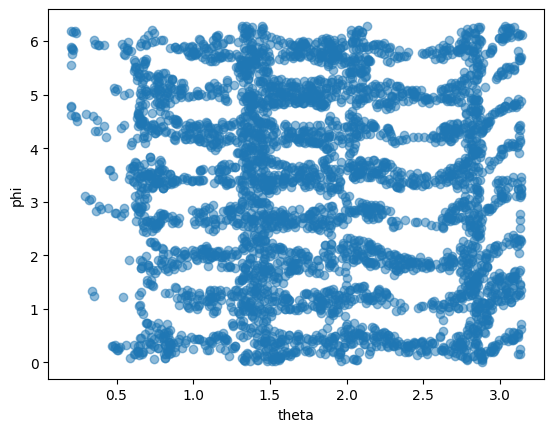

In [6]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(low_fidelities['theta'], low_fidelities['phi'], alpha=0.5)
plt.xlabel('theta')
plt.ylabel('phi')
plt.show()

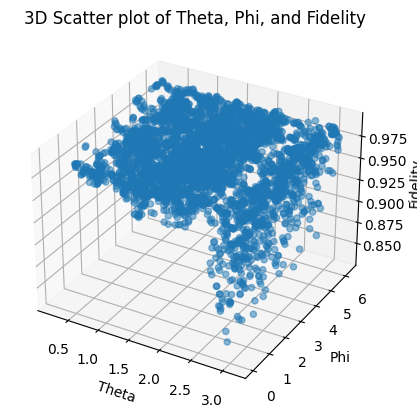

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3차원 그래프 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(low_fidelities['theta'], low_fidelities['phi'], low_fidelities['fidelity'], alpha=0.5)
ax.set_xlabel('Theta')
ax.set_ylabel('Phi')
ax.set_zlabel('Fidelity')
plt.title('3D Scatter plot of Theta, Phi, and Fidelity')
plt.show()
